<a href="https://colab.research.google.com/github/Arumat546/nico_cls/blob/main/%E3%83%8B%E3%82%B3%E3%83%8B%E3%82%B3FASTTEXT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q gwpy
%cd /content/drive/My Drive/Google Colab/niconico_dataset_add_smid/

# 乱数シードの固定
import os
import random
import numpy as np

SEED_VALUE = 123  # これはなんでも良い
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

     |████████████████████████████████| 1.4MB 9.6MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 2.6MB 26.6MB/s 
/content/drive/My Drive/Google Colab/niconico_dataset_add_smid


In [2]:
%%capture
!pip install fasttext
# fasttext
import fasttext as ft
import pandas as pd
import numpy as np
# 正規表現
import re
# グラフ描画
import seaborn as sns
# 混同行列
from sklearn.metrics import confusion_matrix
# 画像表示
import itertools

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
!pip install japanize_matplotlib
import japanize_matplotlib
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [3]:
# MeCabの用意
%%capture
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.5
!pip install unidic-lite
!pip install fugashi
!pip install ipadic
import ipadic

## **データのロードと分かち書き**

In [ ]:
#どっかで使うかも
# ラベル名を数値１桁に変換する関数
# 文字列ラベル名は扱いにくいため
# __label__0 〜 __label3__を順に1,2,3,4に変換
def mklabel(label):
    resp = 0

    if label == '__label__0':
        resp = 0
    elif label == '__label__1':
        resp = 1
    return resp
"""
    elif label == '__label__2':
        resp = 2
    elif label == '__label__3':
        resp = 3
    else:
        resp = 4
"""


"\n    elif label == '__label__2':\n        resp = 2\n    elif label == '__label__3':\n        resp = 3\n    else:\n        resp = 4\n"

In [37]:
%cd /content/drive/MyDrive/Google Colab/niconico_dataset_add_smid
import MeCab
mecab = MeCab.Tagger("-Owakati")
# 学習データを加工
with open('trainAS.tsv', 'r') as f_in, open('train_fasttext.txt', 'w') as f_out:
    for row in f_in:
        content, category = row.strip().split('\t')
        content=mecab.parse(content)
        f_out.write('__label__{} {}\n'.format(category, content))

# テストデータを加工
with open('testAS.tsv', 'r') as f_in, open('test_fasttext.txt', 'w') as f_out:
    for row in f_in:
        content, category = row.strip().split('\t')
        content=mecab.parse(content)
        f_out.write('__label__{} {}\n'.format(category, content))

/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid


"\n# テストデータを加工\nwith open('testAS.tsv', 'r') as f_in, open('test_fasttext.txt', 'w') as f_out:\n    for row in f_in:\n        content, category = row.strip().split('\t')\n        content=mecab.parse(content)\n        f_out.write('__label__{} {}\n'.format(category, content))\n        "

## **訓練**

In [6]:
model = ft.train_supervised(input="train_fasttext.txt", epoch=50,loss="hs")
#model.save_model("fasttext.model")
#results = model.test("test_fasttext.txt")
print("TrainData:", model.test('train_fasttext.txt'))
print("Valid", model.test('test_fasttext.txt'))

TrainData: (4799, 0.9995832465096895, 0.9995832465096895)
Valid (1199, 0.8148457047539617, 0.8148457047539617)


In [ ]:
#他引数例
"""
input             # training file path (required)
lr                # learning rate [0.1]
dim               # size of word vectors [100]
ws                # size of the context window [5]
epoch             # number of epochs [5]
minCount          # minimal number of word occurences [1]
minCountLabel     # minimal number of label occurences [1]
minn              # min length of char ngram [0]
maxn              # max length of char ngram [0]
neg               # number of negatives sampled [5]
wordNgrams        # max length of word ngram [1]
loss              # loss function {ns, hs, softmax, ova} [softmax]
bucket            # number of buckets [2000000]
thread            # number of threads [number of cpus]
lrUpdateRate      # change the rate of updates for the learning rate [100]
t                 # sampling threshold [0.0001]
label             # label prefix ['__label__']
verbose           # verbose [2]
pretrainedVectors # pretrained word vectors (.vec file) for supervised learning []
"""

## **推論**

In [ ]:
#文章ごとに推測
import MeCab
mecab = MeCab.Tagger("-Owakati")
pdtext="うっうー"
pdtext_w=mecab.parse(pdtext)
print(pdtext_w)

ret=model.predict("うっ う ー ")

print(ret)

#0 政治　1 動物
#0ボカロ　1アイマス　2東方

うっ う ー 

(('__label__0',), array([0.64758641]))


In [42]:
#validデータを用いた精度確認
with open("train_fasttext.txt") as f:
    l_strip = [s.strip() for s in f.readlines()] # strip()を利用することにより改行文字除去

labels = []
texts = []
sizes = []
count=0
for t in l_strip:
  if count %2 == 0:
    labels.append(re.findall('__label__[01] ', t)[0])###################カテゴリ数
    texts.append(re.findall(' (.*)', t)[0])
    sizes.append(model.predict(re.findall(' (.*)', t))[1][0][0])
  count += 1

#適当な例で実験
print("正解ラベル:{}".format(labels[10]))
print(texts[10])
print(model.predict(texts[10], k=2))##########################kはカテゴリ数の表示上位設定

正解ラベル:__label__0 
今回 は 良い 内容 だっ た な
(('__label__0', '__label__1'), array([0.99245703, 0.00756298]))


In [ ]:
#個々のベクトル表現を得るには
t="猫 と 犬 で 迷う"
www=model.get_sentence_vector(t)
print(www)

## **可視化**

In [43]:
#記事一つ一つに対してベクトルを取得し、リストに格納
vectors = []
for t in texts:
  texvec=model.get_sentence_vector(t)
  vectors.append(texvec)

#numpy配列に変更
vectors = np.array(vectors)
labels = np.array(labels)
sizes = np.array(sizes)


#StandardScalerを用いてベクトルを標準化
ss = preprocessing.StandardScaler()
vectors_std = ss.fit_transform(vectors)

#主成分分析器PCAを用いて次元削減
pca = PCA()
pca.fit(vectors_std)
feature = pca.transform(vectors_std)
feature = feature[:, :2]#2次元ベクトルに変換

In [ ]:
print(sizes)

In [25]:
#cos類似度計算
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

print("<{}><{}>".format(labels[0], labels[5]))
cos_sim(vectors[0], vectors[5])

<__label__1 ><__label__1 >


0.9682499

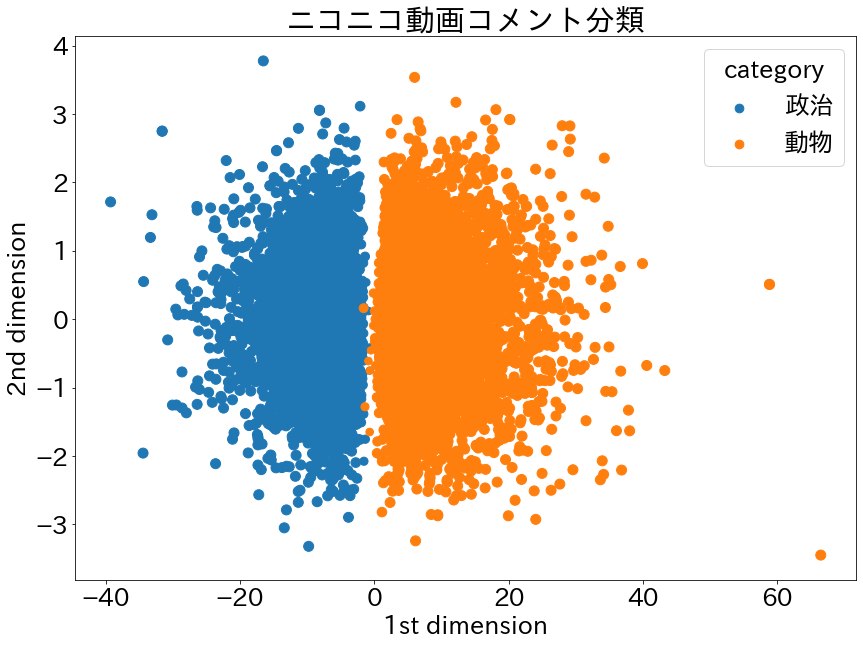

In [47]:
#ベクトルを2次元プロット(sizesの数値によって点の大きさが変化)
x0=[]
x1=[]
x2=[]
y0=[]
y1=[]
y2=[]
z0=[]
z1=[]
z2=[]

#正解ラベルごとのベクトル値を格納
x0, y0, z0 = feature[labels=='__label__0 ', 0], feature[labels=='__label__0 ', 1], sizes[labels=='__label__0 ']*100
x1, y1, z1 = feature[labels=='__label__1 ', 0], feature[labels=='__label__1 ', 1], sizes[labels=='__label__1 ']*100
#x2, y2, z2 = feature[labels=='__label__2 ', 0], feature[labels=='__label__2 ', 1], sizes[labels=='__label__2 ']*100

#x2, y2, z2 = feature[labels=='ライフ', 0], feature[labels=='ライフ', 1], sizes[labels=='ライフ']*1000
#x3, y3, z3 = feature[labels=='国内', 0], feature[labels=='国内', 1], sizes[labels=='国内']*1000
#x4, y4, z4 = feature[labels=='国際', 0], feature[labels=='国際', 1], sizes[labels=='国際']*1000
#x5, y5, z5 = feature[labels=='地域', 0], feature[labels=='地域', 1], sizes[labels=='地域']*1000
#x6, y6, z6 = feature[labels=='経済', 0], feature[labels=='経済', 1], sizes[labels=='経済']*1000

"""
count=0
for ftr in feature:
  if labels[count] == '__label__0 ':
    x0.append(ftr[0])
    y0.append(ftr[1])
    z0.append(sizes[count]*100)
  elif labels[count] == '__label__1 ':
    x1.append(ftr[0])
    y1.append(ftr[1])
    z1.append(sizes[count]*100)
  elif labels[count] == '__label__2 ':
    x2.append(ftr[0])
    y2.append(ftr[1])
    z2.append(sizes[count]*100)
  count += 1  
"""

plt.figure(figsize=(14, 10))
plt.rcParams["font.size"]=25
plt.scatter(x0, y0, label="政治", s=z0)
plt.scatter(x1, y1, label="動物", s=z1)
#plt.scatter(x2, y2, label="アイマス", s=z2)
#plt.scatter(x2, y2, label="ライフ", s=z2)
#plt.scatter(x3, y3, label="国内", s=z3)
#plt.scatter(x4, y4, label="国際", s=z4)
#plt.scatter(x5, y5, label="地域", s=z5)
#plt.scatter(x6, y6, label="経済", s=z6)
plt.title("ニコニコ動画コメント分類")
plt.xlabel('1st dimension')
plt.ylabel('2nd dimension')
plt.legend(title="category")
plt.show()

## **不要**

In [ ]:
%cd /content/drive/My Drive/Google Colab/niconico_dataset_add_smid/fasttext
import MeCab
import csv
import re
mecab = MeCab.Tagger("-Owakati")

wakati = []

#入力ファイル
with open('Sfast.csv') as f:
    reader = csv.reader(f)
    for row in reader:
      row[1]=mecab.parse(row[1])
      mecab.parse('')
      wakati.append(row)

#出力ファイル
with open('./fast/Sfast_w.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerows(wakati)

/content/drive/My Drive/Google Colab/niconico_dataset_add_smid/fasttext


In [ ]:
#データラベルの置換
%cd /content/drive/My Drive/Google Colab/niconico_dataset_add_smid/fasttext

rep=[]

with open('Sfast.csv') as f:
    reader = csv.reader(f)
    for row in reader:
      row[0]=row[0].replace("政治", "__label__0")
      rep.append(row)

#出力ファイル
with open('Sfast.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerows(rep)

/content/drive/My Drive/Google Colab/niconico_dataset_add_smid/fasttext


In [ ]:
#csv出力
%cd /content/drive/My Drive/Google Colab/niconico_dataset_add_smid/
import pandas as pd
import sqlite3

i=0
df = pd.DataFrame(index=[], columns=['category','content'])

con = sqlite3.connect("2525.db")
c = con.cursor()
c.execute("select content,category from comment inner join video on comment.video_id=video.video_id where length(content)>=8 and category='政治'")
for row in c: # rowはtuple
    #print(row[0], row[1])
    df.loc[i]=[row[1], row[0]]
    i+=1

#df.head()
#データをシャッフル
df = df.sample(frac=1, random_state=121).reset_index(drop=True)


#取り出すデータ数指定
df[:1000].to_csv('/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/fasttext/Sfast.csv', index=False, header=None)

#print(df[:len].shape)
#df.to_csv('/content/entame.tsv', sep='\t', index=False)
con.commit()
con.close()

In [ ]:
%cd /content/drive/MyDrive/Google Colab/niconico_dataset_add_smid
#分かち書き
import MeCab
import csv
import re
mecab = MeCab.Tagger("-Owakati")

wakati = []
wakati_test = []

#訓練######################
#入力ファイル
with open('train.tsv') as f:
    reader = csv.reader(f,delimiter='\t')
    for row in reader:
      row[0]=mecab.parse(row[0])
      #mecab.parse('')
      wakati.append(row)

#出力ファイル
with open('/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/fasttext/train_w.tsv', 'w') as f:
  writer = csv.writer(f,delimiter='\t', lineterminator='\n')
  writer.writerows(wakati)

#テスト#####################
#入力ファイル
with open('test.tsv') as f:
    reader = csv.reader(f,delimiter='\t')
    for row in reader:
      row[0]=mecab.parse(row[0])
      #mecab.parse('')
      wakati_test.append(row)

#出力ファイル
with open('/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/fasttext/test_w.tsv','w') as f:
  writer = csv.writer(f,delimiter='\t', lineterminator='\n')
  writer.writerows(wakati_test)


/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid
